In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from refik_lib.costs import compute_mse
from refik_lib.ridge_regression import ridge_regression
from refik_lib.build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    
    # Preparing the test and training data sets
    ind = range(y.shape[0])
    ind_te = k_indices[k]
    ind_tr = list(set(ind) - set(ind_te))
    y_tr, y_te = y[ind_tr], y[ind_te]
    x_tr, x_te = x[ind_tr], x[ind_te]
    
    # Building polynomial data, feature expansion
    x_ply_tr = build_poly(x_tr, degree)
    x_ply_te = build_poly(x_te, degree)

    # Getting weights for ridge regression
    w = ridge_regression(y_tr, x_ply_tr, lambda_)
    
    # Computing loss from training and test data
    loss_tr = compute_mse(y_tr, x_ply_tr, w)
    loss_te = compute_mse(y_te, x_ply_te, w)

    return loss_tr, loss_te

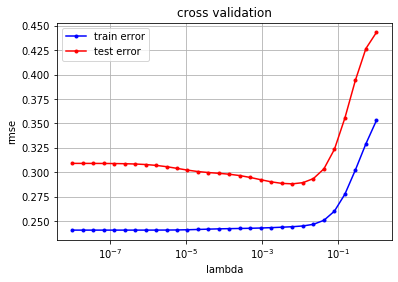

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo(y=y, x=x, degree = 7, viz=True):
    seed = 1
    k_fold = 4
    lambdas = np.logspace(-8, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    for lambda_ in lambdas:
        loss = [cross_validation(y, x, k_indices, k, lambda_, degree) 
                for k in range(k_fold)]
        k_rmse_tr, k_rmse_te = np.sqrt(np.mean(loss, axis=0))
        rmse_tr.append(k_rmse_tr)
        rmse_te.append(k_rmse_te)
    
    if viz:
        cross_validation_visualization(lambdas, rmse_tr, rmse_te)

    return lambdas, rmse_tr, rmse_te
    
_, _, _ = cross_validation_demo(viz=True)

### Selecting the best polynomial degree for the model

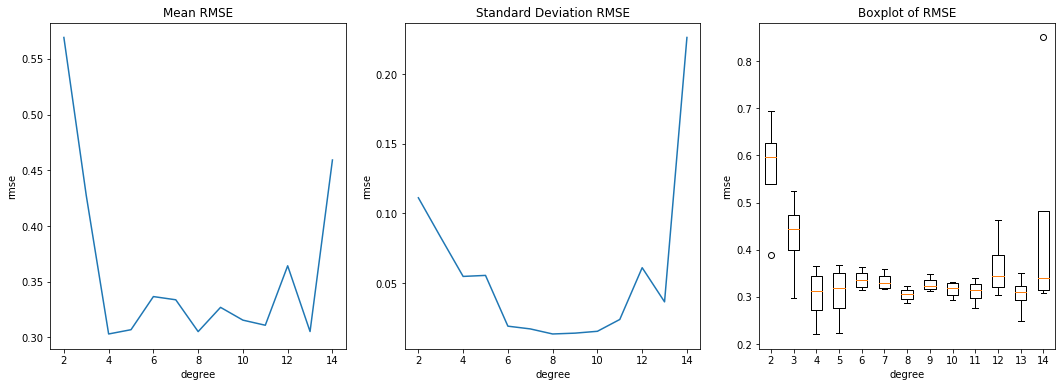

In [6]:
def select_model_degree(min_d=2, max_d=14):
    seed = 1
    k_fold = 4
    lambda_ = 0.1
    degrees = list(range(min_d, max_d+1))
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of test data
    rmse_te = []
    rmse_sd_te = []
    rmse_te_lst = []
    
    for degree in degrees:
        loss = [cross_validation(y, x, k_indices, k, lambda_, degree) 
                for k in range(k_fold)]
        d_rmse_tr,    d_rmse_te    = np.mean(np.sqrt(loss), axis=0)
        d_rmse_sd_tr, d_rmse_sd_te = np.std(np.sqrt(loss), axis=0)
        rmse_te.append(d_rmse_te)
        rmse_sd_te.append(d_rmse_sd_te)
        rmse_te_lst.append(np.sqrt([l[1] for l in loss]))
    
    fig, ax_lst = plt.subplots(1,3, figsize=(18, 6))

    ax_lst[0].plot(degrees, rmse_te)
    ax_lst[0].set_title("Mean RMSE")
    ax_lst[1].plot(degrees, rmse_sd_te)
    ax_lst[1].set_title("Standard Deviation RMSE")
    ax_lst[2].boxplot(rmse_te_lst, labels=degrees)
    ax_lst[2].set_title("Boxplot of RMSE")
    [ax.set_xlabel('degree') for ax in ax_lst]
    [ax.set_ylabel('rmse') for ax in ax_lst]
    
    return rmse_te, rmse_te_lst
    
_ = select_model_degree()        

Looks like any degree above 4 looks OK. 

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

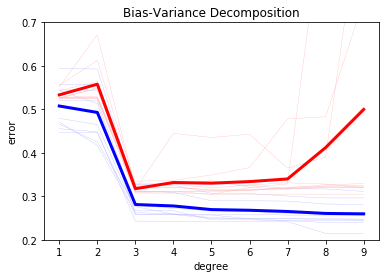

In [10]:
from refik_lib.least_squares import least_squares
from refik_lib.split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(10)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        for index_degree, degree in enumerate(degrees):
            # Splitting data into training and test sets 
            x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)

            x_tr = build_poly(x_tr, degree)
            x_te = build_poly(x_te, degree)
            
            # Computing the weights
            w = least_squares(y_tr, x_tr)
            
            # Adding the loss for train and test
            rmse_tr[index_seed, index_degree] = np.sqrt(compute_mse(y_tr, x_tr, w))
            rmse_te[index_seed, index_degree] = np.sqrt(compute_mse(y_te, x_te, w))

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
    
    return degrees, rmse_te, rmse_tr

degrees, rmse_te, rmse_tr = bias_variance_demo()

## Box Plot for Test Error

Text(0.5, 0, 'degree')

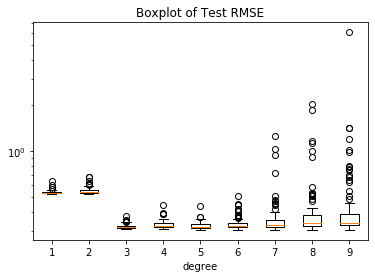

In [8]:
plt.boxplot(rmse_te, labels=degrees)
axes = plt.gca()
axes.set_title('Boxplot of Test RMSE')
axes.set_yscale('log')
axes.set_xlabel('degree')

## Bias Variance Decomposition using Ridge Regression

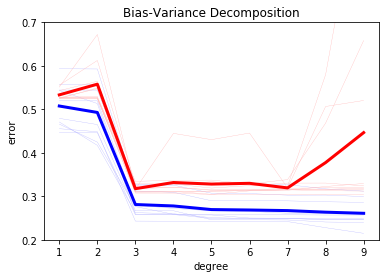

In [9]:
def bias_variance_ridge_demo():
    """The entry."""
    # define parameters
    seeds = range(10)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    best_lambdas = []
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T

        for index_degree, degree in enumerate(degrees):            
            # Splitting data into training and test sets 
            x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
            
            # Finding the best lambda
            lambdas, _, cv_rmse_te = cross_validation_demo(y, x, degree, viz=False)
            min_rmse_ind = np.argmin(cv_rmse_te)
            best_lambda = lambdas[min_rmse_ind]
            
            x_tr = build_poly(x_tr, degree)
            x_te = build_poly(x_te, degree)
            
            # Computing the weights
            w = ridge_regression(y_tr, x_tr, best_lambda)
            
            # Adding the loss for train and test
            rmse_tr[index_seed, index_degree] = np.sqrt(compute_mse(y_tr, x_tr, w))
            rmse_te[index_seed, index_degree] = np.sqrt(compute_mse(y_te, x_te, w))

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
    
    return degrees, rmse_te, rmse_tr

_ = bias_variance_ridge_demo()

The difference with this is that you get less error on higher degrees and less variance for the testing data.